In [1]:
import os

dataset_path = "/kaggle/input/depression/Dataset"
train_dir = os.path.join(dataset_path, "training")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "testsets")

print("Dataset Path Set!")

Dataset Path Set!


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0

In [3]:
# Image size expected by EfficientNet
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_data = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_data = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

print("Data Loaded Successfully!")

Found 16141 images belonging to 2 classes.
Found 2622 images belonging to 2 classes.
Found 2071 images belonging to 2 classes.
Data Loaded Successfully!


In [4]:
def build_fcn(input_shape=(224, 224, 3)):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    
    return Model(inputs=base_model.input, outputs=x, name="FCN_Model")

print("FCN Model Ready!")

FCN Model Ready!


In [5]:
def fusion_fuzzy_logic_layer(inputs):
    fuzzy_output = Dense(64, activation="tanh")(inputs)
    return fuzzy_output

print("Fusion Fuzzy Logic Layer Ready!")

Fusion Fuzzy Logic Layer Ready!


In [6]:
def build_lstm(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=False)(inputs)
    return Model(inputs, x, name="LSTM_Model")

print("LSTM Model Ready!")

LSTM Model Ready!


In [7]:
from tensorflow.keras.layers import Lambda

def build_hybrid_model(input_shape=(224, 224, 3)):
    fcn_model = build_fcn(input_shape)
    
    fcn_features = fcn_model.output
    fuzzy_output = fusion_fuzzy_logic_layer(fcn_features)
    
    lstm_input = Lambda(lambda x: tf.expand_dims(x, axis=1))(fuzzy_output)
    
    # ✅ FIX: Ensure lstm_input shape is compatible
    lstm_model = build_lstm((1, int(fuzzy_output.shape[-1])))
    
    lstm_output = lstm_model(lstm_input)
    
    final_output = Dense(1, activation='sigmoid')(lstm_output)
    
    model = Model(inputs=fcn_model.input, outputs=final_output, name="Hybrid_Depression_Model")
    
    return model

In [8]:
input_shape = (224, 224, 3)
model = build_hybrid_model(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, validation_data=val_data, epochs=10)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


505/505 ━━━━━━━━━━━━━━━━━━━━ 182s 285ms/step - accuracy: 0.8184 - loss: 0.4030 - val_accuracy: 0.5789 - val_loss: 0.6837
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 138s 271ms/step - accuracy: 0.9124 - loss: 0.2276 - val_accuracy: 0.9073 - val_loss: 0.2301
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 137s 271ms/step - accuracy: 0.9362 - loss: 0.1731 - val_accuracy: 0.9195 - val_loss: 0.2200
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 137s 270ms/step - accuracy: 0.9427 - loss: 0.1530 - val_accuracy: 0.9211 - val_loss: 0.2004
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 138s 273ms/step - accuracy: 0.9473 - loss: 0.1440 - val_accuracy: 0.9115 - val_loss: 0.2466
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 137s 271ms/step - accuracy: 0.9570 - loss: 0.1278 - val_accuracy: 0.9134 - val_loss: 0.2387
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 137s 271ms/step - accuracy: 0.9603 - loss: 0.1128 - val_accuracy: 0.9123 - val_loss: 0.2516
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 137s 270ms/step - accuracy: 0.9642 - loss: 0.10

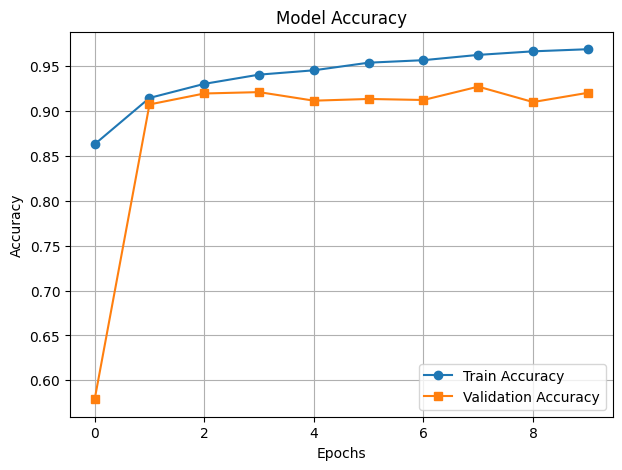

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(7, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Save the model to a specified path
model.save("/kaggle/working/depression_detection_hybrid_model1.h5")

print("Model1 Saved Successfully!")

Model1 Saved Successfully!


In [11]:
model.save("/kaggle/working/depression_detection_hybrid_model2.keras")
print("Model2 Saved Successfully!")

Model2 Saved Successfully!


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values

test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/depression/Dataset/testsets",  # Adjust path if needed
    target_size=(224, 224),  
    batch_size=32,  
    class_mode="binary",  
    shuffle=False
)

Found 2071 images belonging to 2 classes.


In [13]:
import numpy as np

y_true = test_generator.classes  # Actual labels (0: Not Depressed, 1: Depressed)
y_pred_probs = model.predict(test_generator)  # Predicted probabilities
y_pred = np.where(y_pred_probs > 0.5, 1, 0)  # Convert probabilities to binary (threshold = 0.5)

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step


In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1153   31]
 [ 129  758]]


In [15]:
from sklearn.metrics import classification_report, accuracy_score

accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Not Depressed", "Depressed"])

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9227426364075326
Classification Report:
                precision    recall  f1-score   support

Not Depressed       0.90      0.97      0.94      1184
    Depressed       0.96      0.85      0.90       887

     accuracy                           0.92      2071
    macro avg       0.93      0.91      0.92      2071
 weighted avg       0.93      0.92      0.92      2071

